In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

For the ordered pairs $(a_0,a_1), (a_1,a_2), (a_2,a_3),(a_3,a_4)$ with $0 = a_0 \leq a_1 \leq a_2 \leq a_3 \leq a_4$, 
we define each $n_i$ to be the number of people between the ages of $a_{i-1}$ and $a_i$.

Our system of equations to model population change is the following:
$$\dot n_1(t) = \delta_0 n_2(t) -\delta_1 n_1(t)$$
$$\dot n_2(t) = \delta_1 n_1(t) - \delta_2 n_2(t)$$
$$\dot n_3(t) = \delta_2 n_2(t) - \delta_3 n_3(t)$$
$$\dot n_4(t) = \delta_3 n_3(t) - \delta_4 n_4(t)$$

Where $\delta_0 = \frac {b} {2(a_1 - a_0)}$ with birthrate $b$ and $\delta_i = \frac {1}{a_i-a_{i-1}}$


In [2]:
def get_deltas(age_brackets=[18, 40, 65, 85]):
    """
    Helper function that calculates and returns a list of deltas based on birthrate and age brackets.

    Parameters:
    - age_brackets (list): A list of age brackets defining the population segments.

    Returns:
    - list: A list of deltas calculated based on the given birthrate and age brackets.
    """

    # Insert 0 at the beginning of age_brackets to simplify calculations
    M = [0] + age_brackets

    # Calculate deltas based on age brackets
    deltas = [1 / (M[i] - M[i - 1]) for i in range(1, 5)]

    # This is the births delta
    deltas = [.5/(M[2]-M[1])]+deltas

    # Return the modified delta list
    return deltas


In [3]:
def population_SIR(deltas,birthrate = 2):
    """
    Creates a function representing the population dynamics in an SIR (Susceptible-Infectious-Recovered) model.

    Parameters:
    - deltas (list or array): A list or array containing the transition rates between different population compartments.
    - birthrate (int or float or function) The birthrate for the country. Can be constant or a function of time.

    Returns:
    - function: A function representing the population dynamics in the SIR model.
    """

    # Convert deltas to a NumPy array for numerical operations
    d = np.array(deltas)

    def ode(t, n):
        """
        Function representing the rate of change of each population compartment in the SIR model.

        Parameters:
        - t (float): Time parameter (not used in the function, but required for integration).
        - n (array): Array representing the current state of the population compartments.

        Returns:
        - array: Array representing the rate of change of each population compartment.
        """
        DN = np.zeros_like(n)

        # Calculate the rate of change for each compartment based on the SIR model equations
        if callable(birthrate):
            DN[0] = birthrate(t)*d[0] * n[1] - d[1] * n[0]
        else:
            DN[0] = birthrate*d[0] * n[1] - d[1] * n[0]
        DN[1:] = -d[2:] * n[1:] + d[1:-1] * n[:-1]

        return DN
    
    # Return the function representing the population dynamics
    return ode

        

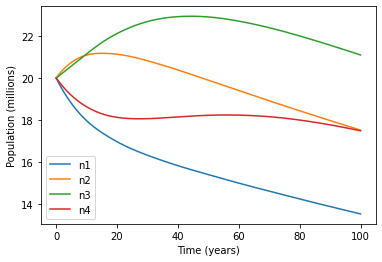

In [7]:
deltas = get_deltas()
ode = population_SIR(deltas,1.8)

ts = np.linspace(0,100,512)
x0 = np.array([20,20,20,20])

sol =solve_ivp(ode,(0,100),x0,t_eval=ts)

plt.plot(sol.t,sol.y.T,label = ["n1","n2","n3","n4"])
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Population (millions)")
plt.show()


In [6]:
%store get_deltas
%store population_SIR
%store sol

Proper storage of interactively declared classes (or instances
of those classes) is not possible! Only instances
of classes in real modules on file system can be %store'd.

Proper storage of interactively declared classes (or instances
of those classes) is not possible! Only instances
of classes in real modules on file system can be %store'd.

Stored 'sol' (OdeResult)
